In [1]:
import torch
import matplotlib.pyplot as plt

from copy import deepcopy
from tqdm.notebook import tqdm

from data_generator import get_test_data, get_train_data
from KCNODE import get_KCNODE_methanation_model

# Training and test data sets generation and normalization

In [2]:
tau_train, inputs_train, outputs_train = get_train_data()
tau_test, inputs_test, outputs_test = get_test_data()

# inputs = molar_flows: CO2, H2, CO, H2O, CH4, N2, independent_parameters:  Temperature, Pressure

inputs_train[:, -1] /= 30 # total pressure
inputs_train[:, -2] += 273.15 # temperature
inputs_train[:, -2] = 10000/8.31*(1/inputs_train[:, -2] - 1/(300+273.15)) # to 'Arrenius' temperature

inputs_train = torch.tensor(inputs_train, requires_grad=True).float()
outputs_train = torch.tensor(outputs_train, requires_grad=True).float()
tau_train = torch.tensor(tau_train, requires_grad=True).float()

inputs_test[:, -1] /= 30 
inputs_test[:, -2] += 273.15
inputs_test[:, -2] = 10000/8.31*(1/inputs_test[:, -2] - 1/(300+273.15))

inputs_test = torch.tensor(inputs_test, requires_grad=True).float()
outputs_test = torch.tensor(outputs_test, requires_grad=True).float()
tau_test = torch.tensor(tau_test, requires_grad=True).float()

# Creating KCNODE model

In [3]:
def loss_func(y_pred, y):        
    err = torch.pow(y_pred[1:, :, :-3] - y[1:, :, :-1], 2).mean()
    return err

model = get_KCNODE_methanation_model(solver='rk4')

Your vector field callable (nn.Module) should have both time `t` and state `x` as arguments, we've wrapped it for you.


# The generalization of the initial model

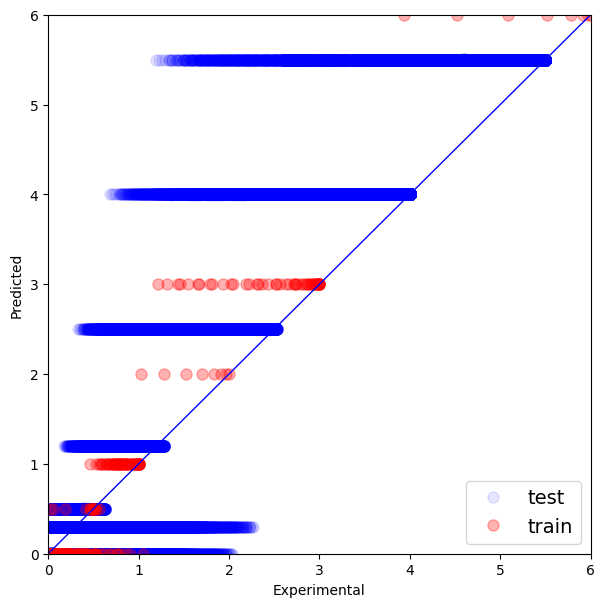

In [4]:
y_pred_train = model(inputs_train, tau_train)[:, :, :-3].detach().numpy().flatten()
y_exp_train = outputs_train[:, :, :-1].detach().numpy().flatten()

y_pred_test = model(inputs_test, tau_test)[:, :, :-3].detach().numpy().flatten()
y_exp_test = outputs_test[:, :, :-1].detach().numpy().flatten()

plt.figure(figsize=(7, 7))


plt.plot(y_exp_test, y_pred_test, 'bo', ms=8, alpha=0.1, label='test')
plt.plot(y_exp_train, y_pred_train, 'ro', ms=8, alpha=0.3, label='train')

plt.plot([0, y_exp_train.max()], [0, y_exp_train.max()], 'b-', lw=1)

plt.xlabel('Experimental')
plt.ylabel('Predicted')

plt.xlim(0, 6)
plt.ylim(0, 6)

plt.legend(fontsize=14)

plt.show()

# Training. RK4

In [5]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=1e-6)

loss_min = 1e5
loss_list = []
            
pbar = tqdm(range(10000))
for epoch in pbar:
    optimizer.zero_grad()
    
    y_pred = model(inputs_train, tau_train)    
    loss = loss_func(y_pred, outputs_train)     
    loss.backward()
    optimizer.step()
    loss_value = loss.detach().numpy()
    
    loss_list.append(loss_value)
    
    if epoch % 10 == 0:
        if loss_min > loss:            
            model_params = deepcopy(model.state_dict())
            loss_min = loss 
        
    pbar.set_description(f"Current loss: {loss_value:e}. Min loss: {loss_min:e}")

  0%|          | 0/10000 [00:00<?, ?it/s]

# Training. Dopri5

In [6]:
model = get_KCNODE_methanation_model(solver='dopri5')
model.load_state_dict(model_params)

optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=1e-6)

pbar = tqdm(range(20000))
for epoch in pbar:
    optimizer.zero_grad()
    
    y_pred = model(inputs_train, tau_train)    
    loss = loss_func(y_pred, outputs_train)     
    loss.backward()
    optimizer.step()
    loss_value = loss.detach().numpy()
    
    loss_list.append(loss_value)
    
    if epoch % 10 == 0:
        if loss_min > loss:            
            model_params = deepcopy(model.state_dict())
            loss_min = loss 
        
    pbar.set_description(f"Current loss: {loss_value:e}. Min loss: {loss_min:e}")

Your vector field callable (nn.Module) should have both time `t` and state `x` as arguments, we've wrapped it for you.


  0%|          | 0/20000 [00:00<?, ?it/s]

In [7]:
# moved out of prev. cell
model.load_state_dict(model_params)

<All keys matched successfully>

# The generalization of the trained model

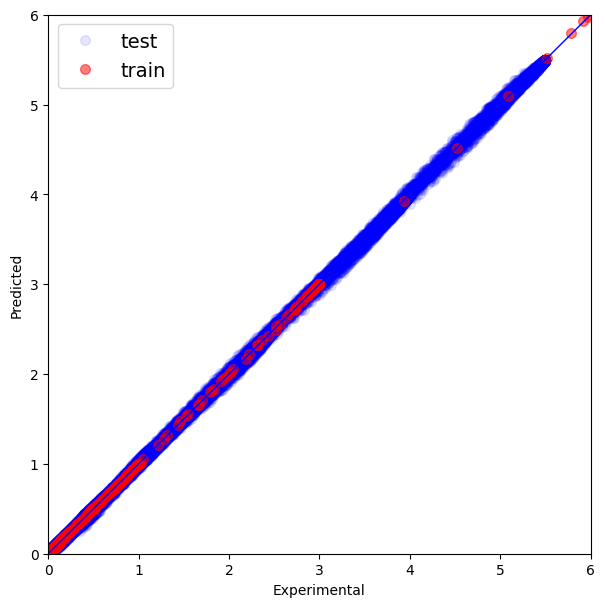

In [8]:
y_pred_train = model(inputs_train, tau_train)[:, :, :-3].detach().numpy().flatten()
y_exp_train = outputs_train[:, :, :-1].detach().numpy().flatten()

y_pred_test = model(inputs_test, tau_test)[:, :, :-3].detach().numpy().flatten()
y_exp_test = outputs_test[:, :, :-1].detach().numpy().flatten()

plt.figure(figsize=(7, 7))


plt.plot(y_exp_test, y_pred_test, 'bo', ms=7, alpha=0.1, label='test')
plt.plot(y_exp_train, y_pred_train, 'ro', ms=7, alpha=0.5, label='train')

plt.plot([0, y_exp_train.max()], [0, y_exp_train.max()], 'b-', lw=1)

plt.xlabel('Experimental')
plt.ylabel('Predicted')

plt.xlim(0, 6)
plt.ylim(0, 6)

plt.legend(fontsize=14)

plt.show()

# The process of the training of ANN

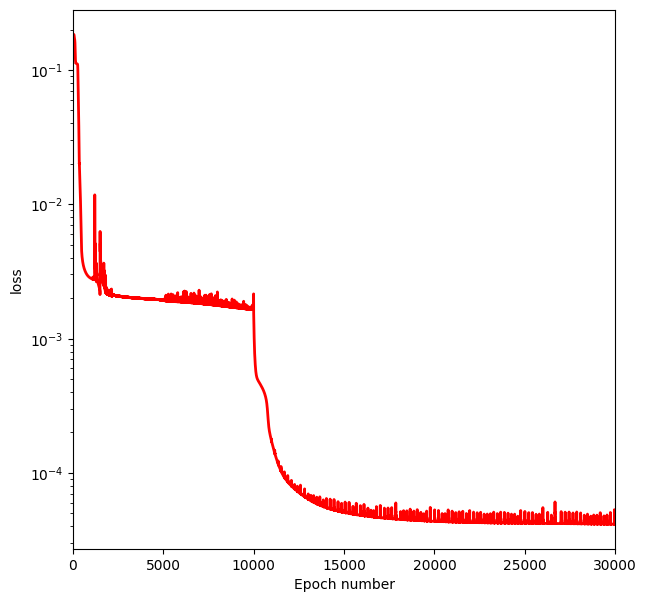

In [9]:
plt.figure(figsize=(7, 7))

plt.plot(range(len(loss_list)), loss_list, 'r-', lw=2)

plt.xlabel('Epoch number')
plt.ylabel('loss')
plt.yscale('log')

plt.xlim(0, len(loss_list))
plt.show()

In [3]:
4*8*2

64